# Python MAGIC EMT tutorial

## MAGIC (Markov Affinity-Based Graph Imputation of Cells)

- MAGIC imputes missing data values on sparse data sets, restoring the structure of the data
- It also proves dimensionality reduction and gene expression visualizations
- MAGIC can be performed on a variety of datasets
- Here, we show the effectiveness of MAGIC on epithelial-to-mesenchymal transition (EMT) data
    
Markov Affinity-based Graph Imputation of Cells (MAGIC) is an algorithm for denoising and transcript recover of single cells applied to single-cell RNA sequencing data, as described in Van Dijk D et al. (2018), Recovering Gene Interactions from Single-Cell Data Using Data Diffusion, Cell https://www.cell.com/cell/abstract/S0092-8674(18)30724-4.

This tutorial shows loading, preprocessing, MAGIC imputation and visualization of myeloid and erythroid cells in mouse bone marrow, as described by Paul et al., 2015. You can edit it yourself at https://colab.research.google.com/github/KrishnaswamyLab/MAGIC/blob/master/python/tutorial_notebooks/bonemarrow_tutorial.ipynb

### Table of Contents

<a href='#install'>Installation</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#magic'>Running MAGIC</a>
<br/>
<a href='#genes'>Visualizing gene-gene interactions</a>
<br/>
<a href='#manifold'>Visualizing cell trajectories with PCA on MAGIC and PHATE</a>
<br/>
<a href='#postprocess'>Using MAGIC data in downstream analysis</a>


<a id="install"></a>

### Installation 

If you haven't yet installed MAGIC, we can install it directly from this Jupyter Notebook.

In [13]:
!pip install --user git+git://github.com/KrishnaswamyLab/MAGIC.git#subdirectory=python

  Cloning git://github.com/KrishnaswamyLab/MAGIC.git to /tmp/pip-req-build-fm6r_kos
  Running setup.py bdist_wheel for magic ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-zrvk1py8/wheels/8c/34/81/1e929fa29dc80dfe23a343266d8ca3e007d9d3ce6fe899d112
Successfully built magic


### Importing MAGIC

Here, we'll import MAGIC along with other popular packages that will come in handy.

In [3]:
import magic

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

### Loading Data

Load your data using one of the following `magic.io` methods: `load_csv`, `load_tsv`, `load_fcs`, `load_mtx`, `load_10x`. You can read about how to use them with `help(magic.io.load_csv)` or on https://magic.readthedocs.io/.


In [4]:
bmmsc_data = magic.io.load_csv('https://github.com/KrishnaswamyLab/PHATE/raw/master/data/BMMC_myeloid.csv.gz')
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010B08Rik;Gm14434;Gm14308,...,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,mszf84;Gm14288;Gm14435;Gm8898,mt-Nd4,mt3-mmp;Mmp16,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
W31106,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
W31107,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,2
W31108,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,0
W31109,0,0,1,0,0,0,0,1,3,0,...,0,0,0,0,0,5,0,0,0,0


<a id="data"></a>

### Data Preprocessing

#### Filtering your data

After loading your data, you're going to want to determine the molecule per cell and molecule per gene cutoffs with which to filter the data, in order to remove lowly expressed genes and cells with a small library size.


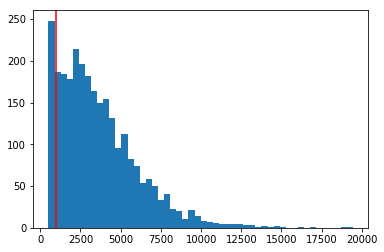

In [5]:
libsize = bmmsc_data.sum(axis=1)
plt.hist(libsize, bins=50)
plt.axvline(1000, c='r')
plt.show()

In [6]:
bmmsc_data = bmmsc_data.loc[libsize > 1000]
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010B08Rik;Gm14434;Gm14308,...,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,mszf84;Gm14288;Gm14435;Gm8898,mt-Nd4,mt3-mmp;Mmp16,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
W31107,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,2
W31108,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,0
W31109,0,0,1,0,0,0,0,1,3,0,...,0,0,0,0,0,5,0,0,0,0
W31110,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,3,0,0,0,1


#### Normalizing your data

After filtering, the next steps are to perform library size normalization and transformation. Log transformation is frequently used for single-cell RNA-seq, however, this requires the addition of a pseudocount to avoid infinite values at zero. We instead use a square root transform, which has similar properties to the log transform but has no problem with zeroes.

In [7]:
bmmsc_data = magic.preprocessing.library_size_normalize(bmmsc_data)
bmmsc_data = np.sqrt(bmmsc_data)
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010B08Rik;Gm14434;Gm14308,...,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,mszf84;Gm14288;Gm14435;Gm8898,mt-Nd4,mt3-mmp;Mmp16,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0.0,0.000000,0.0000,0.924097,0.0,0.0,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.924097,0.924097,0.0,0.0,0.000000
W31107,0.0,0.666882,0.0000,0.943113,0.0,0.0,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.155073,0.666882,0.0,0.0,0.943113
W31108,0.0,0.697502,0.0000,0.697502,0.0,0.0,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.208109,0.697502,0.0,0.0,0.000000
W31109,0.0,0.000000,0.6303,0.000000,0.0,0.0,0.0,0.6303,1.091711,0.0,...,0.0,0.0,0.0,0.0,0.0,1.409393,0.000000,0.0,0.0,0.000000
W31110,0.0,1.207257,0.0000,0.000000,0.0,0.0,0.0,0.0000,1.207257,0.0,...,0.0,0.0,0.0,0.0,0.0,2.091030,0.000000,0.0,0.0,1.207257


<a id="magic"></a>

### Running MAGIC

Now that your data has been preprocessed, you are ready to run MAGIC.

#### Creating the MAGIC operator

If you don't specify any parameters, the following line creates an operator with the following default values: `k=10`, `a=15`, `t='auto'`.

In [8]:
magic_op = magic.MAGIC(k=5)

#### Running MAGIC with gene selection

The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with `genes='all_genes'`.

In [9]:
bmmsc_magic = magic_op.fit_transform(bmmsc_data, genes=["Mpo", "Klf1", "Ifitm1"])
bmmsc_magic.head()

Calculating MAGIC...
Calculating graph and diffusion operator...
Calculating PCA...
Calculated PCA in 5.24 seconds.
Calculating KNN search...
Calculated KNN search in 0.86 seconds.
Calculating affinities...
Calculated affinities in 0.75 seconds.
Calculated graph and diffusion operator in 7.24 seconds.
Calculating imputation...
Automatically selected t = 10
Calculated imputation in 0.67 seconds.
Calculated MAGIC in 9.40 seconds.


,Ifitm1,Klf1,Mpo
W31106,0.391715,0.213165,6.796455
W31107,0.072366,1.846090,1.876940
W31108,0.352682,0.218342,6.933896
W31109,0.073694,1.835748,1.825066
W31110,0.392099,0.285136,6.496423


### Visualizing gene-gene relationships
<a id="genes"></a>

We can see gene-gene relationships much more clearly after applying MAGIC.

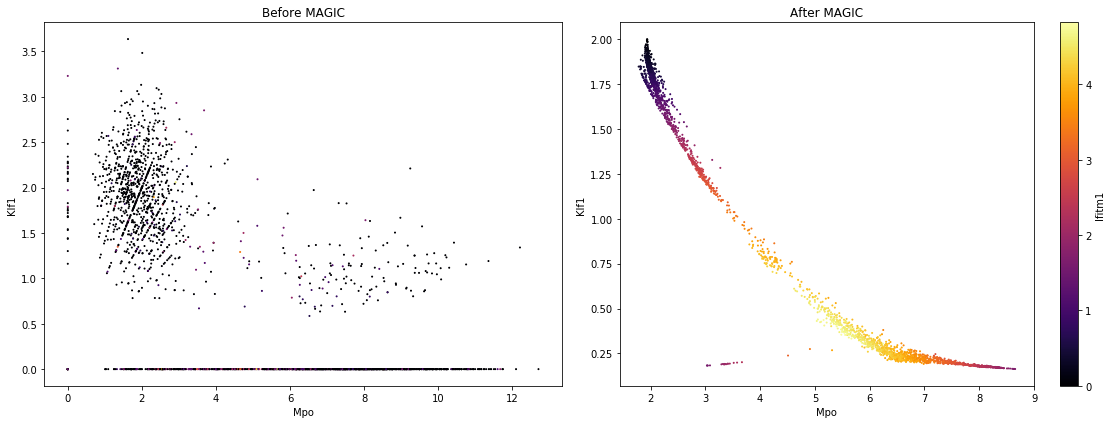

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

points1 = ax1.scatter(bmmsc_data['Mpo'], bmmsc_data['Klf1'], c=bmmsc_data['Ifitm1'], cmap='inferno', s=1)
ax1.set_xlabel('Mpo')
ax1.set_ylabel('Klf1')
ax1.set_title('Before MAGIC')

points2 = ax2.scatter(bmmsc_magic['Mpo'], bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], cmap='inferno', s=1)
ax2.set_xlabel('Mpo')
ax2.set_ylabel('Klf1')
ax2.set_title('After MAGIC')

plt.colorbar(points1, label='Ifitm1')

plt.tight_layout()
plt.show()

The original data suffers from dropout to the point that we cannot infer anything about the gene-gene relationships. As you can see, the gene-gene relationships are much clearer after MAGIC. These relationships also match the biological progression we expect to see - Ifitm1 is a stem cell marker, Klf1 is an erythroid marker, and Mpo is a myeloid marker.

#### Setting the MAGIC operator parameters

If you wish to modify any parameters for your MAGIC operator, you change do so without having to recompute intermediate values using the `magic_op.set_params` method. Since our gene-gene relationship here appears a little too smooth, we can reduce `t` a little from the automatic value of `10` down to a smaller value like `4`.

In [11]:
magic_op.set_params(t=4)

MAGIC(a=15, k=5, knn_dist='euclidean', n_jobs=1, n_pca=100, random_state=None,
   t=4, verbose=1)

We can now run MAGIC on the data again with the new parameters. Given that we have already fitted our MAGIC operator to the data, we should run the `magic_op.transform` method.

In [12]:
bmmsc_magic = magic_op.transform(genes=["Mpo", "Klf1", "Ifitm1"])
bmmsc_magic.head()

Calculating imputation...
Calculated imputation in 0.18 seconds.


,Ifitm1,Klf1,Mpo
W31106,0.357067,0.156717,7.156562
W31107,0.055605,1.930110,1.777277
W31108,0.307409,0.177795,7.221727
W31109,0.050814,1.929978,1.647242
W31110,0.442238,0.208486,6.716422


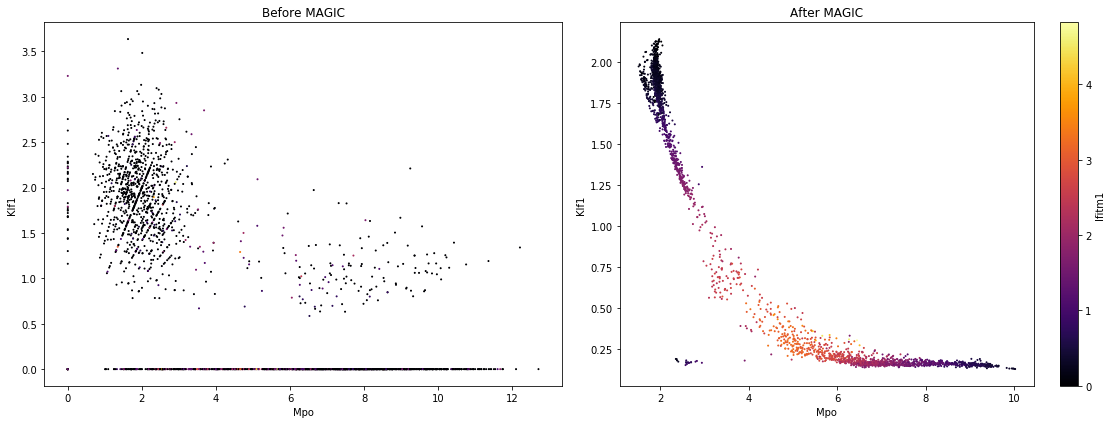

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

points1 = ax1.scatter(bmmsc_data['Mpo'], bmmsc_data['Klf1'], c=bmmsc_data['Ifitm1'], cmap='inferno', s=1)
ax1.set_xlabel('Mpo')
ax1.set_ylabel('Klf1')
ax1.set_title('Before MAGIC')

points2 = ax2.scatter(bmmsc_magic['Mpo'], bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], cmap='inferno', s=1)
ax2.set_xlabel('Mpo')
ax2.set_ylabel('Klf1')
ax2.set_title('After MAGIC')

plt.colorbar(points1, label='Ifitm1')

plt.tight_layout()
plt.show()

That looks better. The gene-gene relationships are restored without smoothing so far as to remove structure.

<a id="manifold"></a>

### Visualizing cell trajectories with PCA on MAGIC

We can extract the principal components of the smoothed data by passing the keyword `genes='pca_only'` and use this for visualizing the data.

In [14]:
bmmsc_magic_pca = magic_op.transform(genes="pca_only")
bmmsc_magic_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
W31106,9.198179,-2.232712,0.322068,2.341508,0.163183,0.069958,-0.436137,0.657573,0.280173,-0.233028,...,0.007882,-0.007769,0.039249,-0.013712,0.037003,0.045341,0.002564,-0.014632,-0.019836,-0.022539
W31107,-13.965376,-3.436010,2.750027,-0.517220,-1.459354,1.534760,0.260222,1.577532,0.631905,-1.217475,...,-0.077996,-0.184937,-0.168592,0.027801,-0.011959,-0.015440,-0.025887,-0.150859,0.081812,0.017785
W31108,8.066881,-4.972006,3.105126,-0.317667,-0.277599,-0.617034,0.312669,2.030841,0.277842,-0.565978,...,0.047301,0.010970,0.015236,0.107672,0.001638,0.065780,-0.035015,-0.135955,0.041692,0.025595
W31109,-13.558019,-2.437581,1.679105,-0.120064,-1.615215,1.846040,-0.068755,2.972539,0.935748,-1.693839,...,-0.047388,-0.208066,-0.185600,-0.003503,-0.049381,0.047872,-0.097261,-0.242983,0.154257,0.018658
W31110,8.124655,-0.723849,0.999795,0.442408,0.198055,-0.558378,-0.042858,0.427602,-0.317407,-0.688777,...,0.039889,0.014121,0.029584,0.004486,0.040359,0.030281,-0.009436,-0.031083,0.007207,-0.003455


In [15]:
from sklearn.decomposition import PCA
bmmsc_pca = PCA(n_components=3).fit_transform(np.array(bmmsc_data))

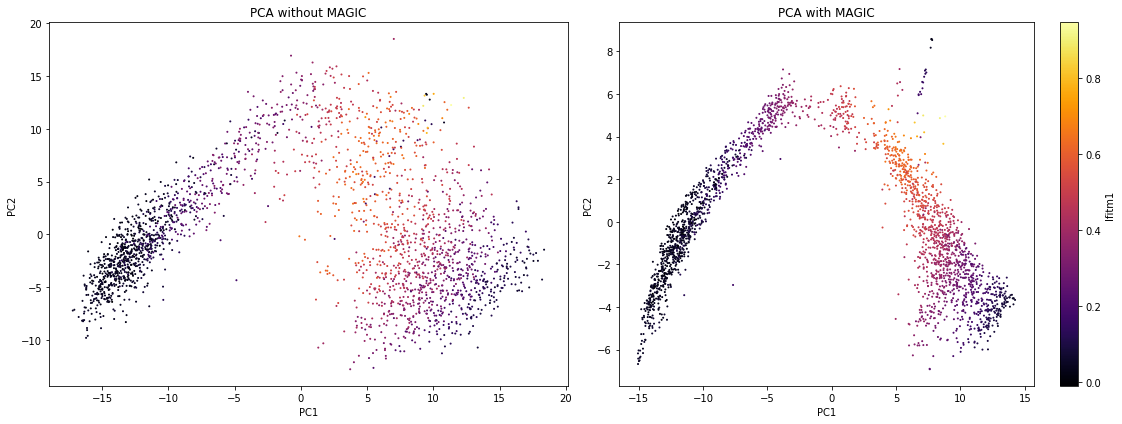

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

points1 = ax1.scatter(bmmsc_pca[:,0], bmmsc_pca[:,1], c=bmmsc_magic['Ifitm1'], cmap='inferno', s=1)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA without MAGIC')

points2 = ax2.scatter(bmmsc_magic_pca["PC1"], bmmsc_magic_pca["PC2"], c=bmmsc_magic['Ifitm1'], cmap='inferno', s=1)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('PCA with MAGIC')


plt.colorbar(points1, label='Ifitm1')
plt.tight_layout()
plt.show()

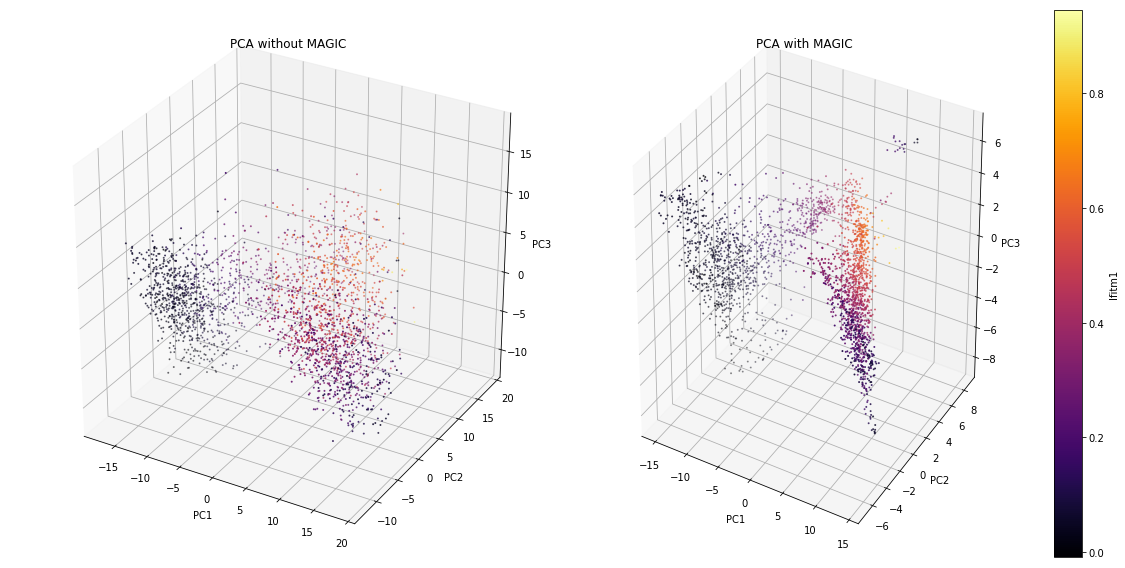

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121, projection='3d')
points1 = ax1.scatter(bmmsc_pca[:,0], bmmsc_pca[:,1], bmmsc_pca[:,2],
                      c=bmmsc_magic['Ifitm1'], cmap='inferno', s=1)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA without MAGIC')

ax2 = fig.add_subplot(122, projection='3d')
points2 = ax2.scatter(bmmsc_magic_pca["PC1"], bmmsc_magic_pca["PC2"], bmmsc_magic_pca["PC3"],
                      c=bmmsc_magic['Ifitm1'], cmap='inferno', s=1)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('PCA with MAGIC')


plt.colorbar(points1, label='Ifitm1')
plt.tight_layout()
plt.show()


### Visualizing MAGIC values with PHATE

In complex systems, two dimensions of PCA are not sufficient to view the entire space. For this, PHATE is a suitable visualization tool which works hand in hand with MAGIC to view how gene expression evolves along a trajectory. For this, you will need to have installed PHATE. For help using PHATE, visit https://phate.readthedocs.io/.

In [ ]:
!pip install --user phate

In [20]:
import phate

In [21]:
data_phate = phate.PHATE(k=4, a=100, t=20).fit_transform(bmmsc_data)

Calculating PHATE...
Calculating graph and diffusion operator...
Calculating PCA...
Calculated PCA in 5.25 seconds.
Calculating KNN search...
Calculated KNN search in 0.68 seconds.
Calculating affinities...
Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 6.47 seconds.
Calculating landmark operator...
Calculating SVD...
Calculated SVD in 0.30 seconds.
Calculating KMeans...
Calculated KMeans in 11.77 seconds.
Calculated landmark operator in 13.23 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.29 seconds.
Calculating metric MDS...
Calculated metric MDS in 70.99 seconds.
Calculated PHATE in 91.98 seconds.


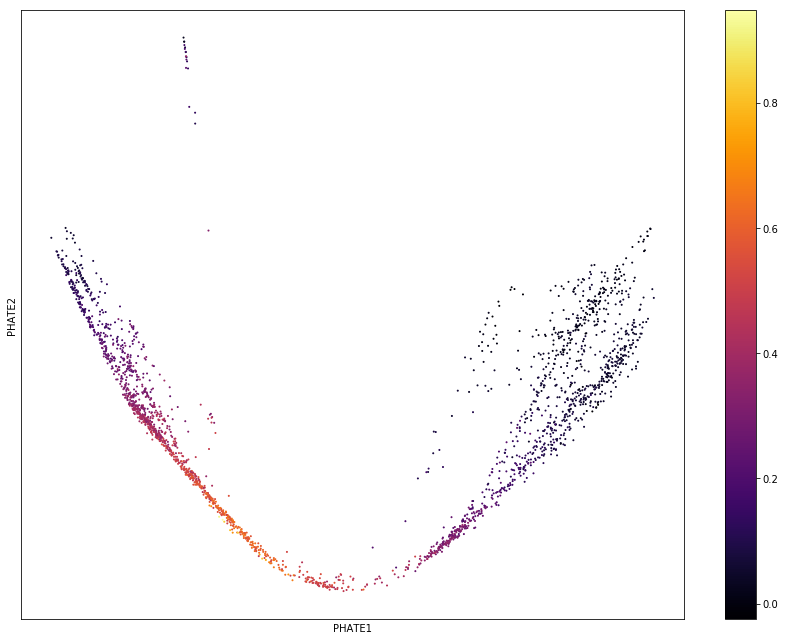

In [16]:
phate.plot.scatter2d(data_phate, c=bmmsc_magic['Ifitm1'], figsize=(12,9))

### Using the MAGIC smoothed data in downstream analysis
<a id="postprocess"></a>

Finally, if you wish to use the full smoothed matrix in any downstream analysis, you can extract it with the keyword `genes="all_genes"`. Note that this matrix may be very large.

In [17]:
bmmsc_magic = magic_op.transform(genes="all_genes")
bmmsc_magic.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010B08Rik;Gm14434;Gm14308,...,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,mszf84;Gm14288;Gm14435;Gm8898,mt-Nd4,mt3-mmp;Mmp16,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0.150623,0.481564,0.049106,0.331832,0.022977,1.901535e-16,0.049101,0.070829,0.159938,-1.881479e-16,...,0.003263,0.021731,0.0,0.0,0.0,0.818334,0.172886,0.112350,0.035940,0.228951
W31107,0.130002,0.393270,0.128257,0.401581,0.042307,-5.065348e-16,0.077764,0.124324,0.385013,-1.309683e-16,...,0.036451,0.010726,0.0,0.0,0.0,1.359045,0.191483,0.016937,0.068044,0.097131
W31108,0.131209,0.550516,0.066490,0.375065,0.023195,5.596347e-16,0.054337,0.057869,0.188030,2.386166e-16,...,0.007362,0.020054,0.0,0.0,0.0,0.898026,0.217576,0.138755,0.040683,0.198915
W31109,0.118781,0.385389,0.116607,0.377146,0.037136,-3.166241e-16,0.066299,0.099375,0.373720,-4.223424e-17,...,0.032477,0.009618,0.0,0.0,0.0,1.369356,0.193816,0.015058,0.061581,0.083856
W31110,0.137754,0.439324,0.042682,0.345729,0.021793,1.987233e-16,0.053028,0.052500,0.160579,-5.333344e-17,...,0.004866,0.015927,0.0,0.0,0.0,0.839043,0.170561,0.109795,0.037950,0.205749
